In [1]:
import numpy as np
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import fsolve
from scipy.optimize import leastsq
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import scipy as sp
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["computer modern roman"],
    "font.size": 20})

plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  # This is added back by InteractiveShellApp.init_path()


In [2]:
## Load data
dataFUS = pd.read_excel(r'FUSsims.xlsx')
dataDDX = pd.read_excel(r'DDXsims.xlsx')

## Constants
## Avogadro
NA=6.02214076E23;
## kT
kT=2.49; #kJ/mol;

## Total Volume
VFUS=np.power(dataFUS.L,3)
p0FUS=kT*(dataFUS.Ntot)/VFUS
VDDX=np.power(dataDDX.L,3)
p0DDX=kT*(dataDDX.Ntot)/VDDX

## Densities
## mg/protein
weightFUS=2.85281E-17;
weightDDX=4.22275E-17;
ml_nm3=1E21;
## 
vlFUS=np.power(0.0185,-1); #nm3 from FUS density from radial density profile
vlDDX=np.power(0.0085,-1); #nm3 from NDDX4 density from radial density profile
## Output data table
print(dataFUS)
print(dataDDX)

  Simulation   L  Ntot  Nss
0      FUS-3  40    50   42
1      FUS-5  50    69   55
2      FUS-6  50    98   86
3      FUS-7  60    84   63
4      FUS-8  60   118  101
5      FUS-9  60   169  153
6     FUS-10  70   133  103
7     FUS-11  70   187  158
8     FUS-12  70   268  243
  Simulation   L  Ntot  Nss
0    NDDX4-5  50    69   45
1    NDDX4-6  50    98   76
2    NDDX4-7  60    84   42
3    NDDX4-8  60   118   84
4    NDDX4-9  60   169  139
5   NDDX4-10  70   133   71
6   NDDX4-11  70   187  130
7   NDDX4-12  70   268  214


In [3]:
#Define Function -> Equilibrium Condition
ERR=lambda tpl, p0, p1, vl, rss, kT, : p1-tpl[0]*np.exp(2*(tpl[1])*vl/(rss*kT)) #         
#Initial Guess

#Fitting BootStrap
REPS=1000

NsimulationsFUS=np.shape(dataFUS.L)[0]
peqFUS=np.zeros(REPS)
sigmaFUS=np.zeros(REPS)

NsimulationsDDX=np.shape(dataDDX.L)[0]
peqDDX=np.zeros(REPS)
sigmaDDX=np.zeros(REPS)

In [4]:
# Bootstrap estimate of the fitted parameters, FUS
for REP in np.arange(0,REPS):
    #choose Nsimulations random simulations (with repetition)
    simulations=np.random.randint(0,NsimulationsFUS,NsimulationsFUS)
    guess=np.random.rand(2);
    p1=kT*(dataFUS.Ntot[simulations]-dataFUS.Nss[simulations])/(VFUS[simulations]-dataFUS.Nss[simulations]*vlFUS)
    p0=kT*(dataFUS.Ntot[simulations])/VFUS[simulations]
    rss=np.power(3*dataFUS.Nss[simulations]*vlFUS/4/np.pi,1/3)
    
    #least squares fitting
    #tplFitted => tuple of fitted parameters
    tplFitted,success=leastsq(ERR,guess,args=(p0, p1, vlFUS,rss,kT),full_output=0,maxfev=1000,ftol=1E-15,gtol=1E-15)

    peqFUS[REP]=tplFitted[0]
    sigmaFUS[REP]=tplFitted[1]

In [5]:
# Bootstrap estimate of the fitted parameters, NDDX4
for REP in np.arange(0,REPS):
    #choose Nsimulations random simulations (with repetition)
    simulations=np.random.randint(0,NsimulationsDDX,NsimulationsDDX)
    guess=np.random.rand(2);
    p1=kT*(dataDDX.Ntot[simulations]-dataDDX.Nss[simulations])/(VDDX[simulations]-dataDDX.Nss[simulations]*vlDDX)
    p0=kT*(dataDDX.Ntot[simulations])/VDDX[simulations]
    rss=np.power(3*dataDDX.Nss[simulations]*vlDDX/4/np.pi,1/3)
    
    #least squares fitting
    #tplFitted => tuple of fitted parameters
    tplFitted,success=leastsq(ERR,guess,args=(p0, p1, vlDDX,rss,kT),full_output=0,maxfev=1000,ftol=1E-15,gtol=1E-15)

    peqDDX[REP]=tplFitted[0]
    sigmaDDX[REP]=tplFitted[1]

The equilibrium density of the FUS dilute phase is: 1.0328974247709821 +/- 0.31459218188608923 mg/ml
The equilibrium density of the NDDX4 dilute phase is: 4.910918895367858 +/- 1.2628952298219869 mg/ml
The surface tension of FUS is: 0.23292961157281017 +/- 0.07092262422671342
The surface tension of NDDX4 is: 0.061415888613433944 +/- 0.03453546631761104


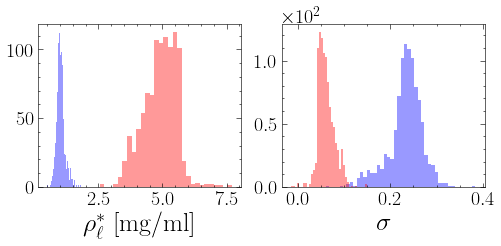

In [6]:
# Equilibrium vapour pressure
peq_FUS_estimate=np.mean(peqFUS)
peq_DDX_estimate=np.mean(peqDDX)

# Equilibrium density of the dilute phase FUS
LD_FUS=peqFUS*ml_nm3*weightFUS/kT; #mg/ml
LD_FUS_estimate=np.mean(LD_FUS)
LD_FUS_err=1.96*np.std(LD_FUS) # 95% confidence interval
# Equilibrium density of the dilute phase NDDX4
LD_DDX=peqDDX*ml_nm3*weightDDX/kT; #mg/ml
LD_DDX_estimate=np.mean(LD_DDX)
LD_DDX_err=1.96*np.std(LD_DDX) # 95% confidence interval
    
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].hist(LD_FUS, bins = 'auto',alpha=0.4,color='blue')
ax[0].hist(LD_DDX, bins = 'auto',alpha=0.4,color='red')
ax[0].set_xlabel('$\\rho_\ell^*$ [mg/ml]',fontsize=26)
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.savefig('panel_2_parameters', dpi=600, bbox_inches='tight');

print('The equilibrium density of the FUS dilute phase is:',LD_FUS_estimate,'+/-',LD_FUS_err,'mg/ml')
print('The equilibrium density of the NDDX4 dilute phase is:',LD_DDX_estimate,'+/-',LD_DDX_err,'mg/ml')

sigma_FUS_estimate=np.mean(sigmaFUS)
sigma_FUS_err=1.96*np.std(sigmaFUS) # 95% confidence interval
sigma_DDX_estimate=np.mean(sigmaDDX)
sigma_DDX_err=1.96*np.std(sigmaDDX) # 95% confidence interval
    
ax[1].hist(sigmaFUS, bins = 'auto',alpha=0.4,color='blue')
ax[1].hist(sigmaDDX, bins = 'auto',alpha=0.4,color='red')
ax[1].set_xlabel('$\\sigma$',fontsize=26)
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.savefig('Fitted_params', dpi=600, bbox_inches='tight');

print('The surface tension of FUS is:',sigma_FUS_estimate,'+/-',sigma_FUS_err)
print('The surface tension of NDDX4 is:',sigma_DDX_estimate,'+/-',sigma_DDX_err)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


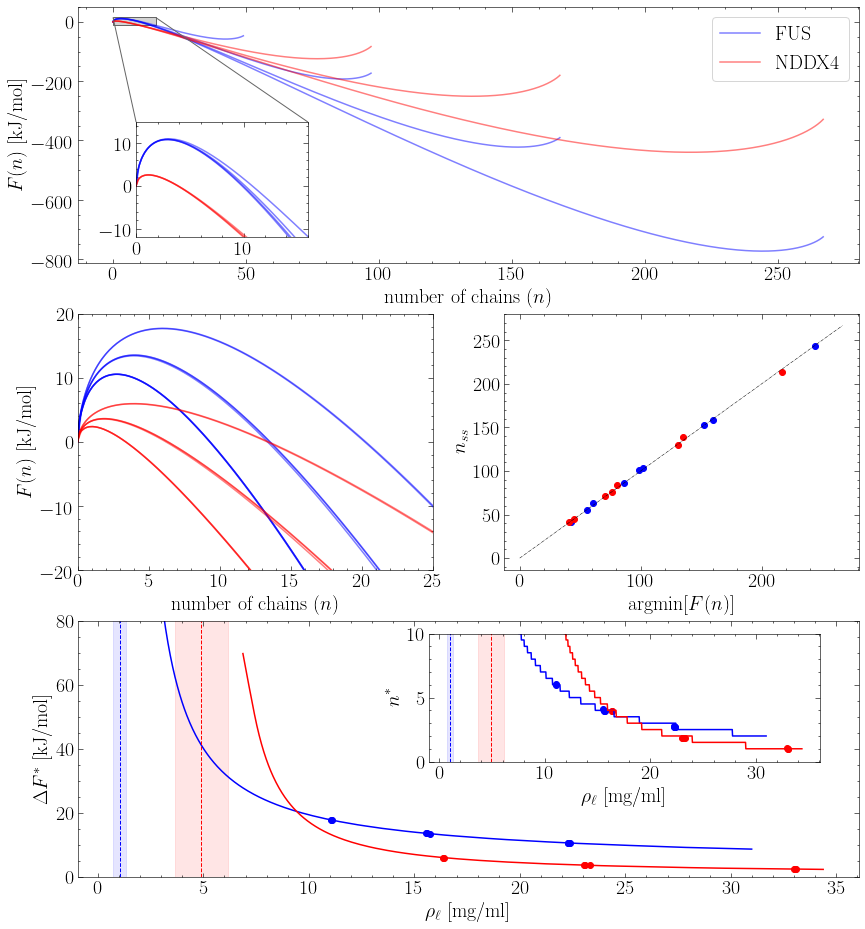

In [7]:
## Define FES confined and macroscopic
FES_confined=lambda nn, N, peq, sigma, p0, p1, vl, r, kT, : -nn*kT*np.log(p1/peq)+sigma*4*np.pi*np.power(r,2)+nn*(kT-vl*peq)+N*kT*np.log(p1/p0);
FES_macro=lambda nn, peq, sigma, p0, r, kT, : -nn*kT*np.log(p0/peq)+sigma*4*np.pi*np.power(r,2);

## Plot sub-figures setup
fig = plt.figure(figsize=(14, 16))
sub1 = fig.add_subplot(3,2,(1,2))
sub2 = fig.add_subplot(3,2,3)
sub3 = fig.add_subplot(3,2,4)
sub4 = fig.add_subplot(3,2,(5,6))

## labels
sub1.set_xlabel('number of chains ($n$)')
sub1.set_ylabel('$F(n)$ [kJ/mol]')
sub2.set_xlabel('number of chains ($n$)')
sub2.set_ylabel('$F(n)$ [kJ/mol]')
sub3.set_xlabel('argmin$[F(n)]$')
sub3.set_ylabel('$n_{ss}$')
sub4.set_xlabel('$\\rho_\ell$ [mg/ml]')
sub4.set_ylabel('$\\Delta{F}^*$ [kJ/mol]')

## insets
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(sub1, [0.075,0.1,0.22,0.45])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines.
ax2.set_xlim([0,16])
ax2.set_ylim([-12,15]) 
mark_inset(sub1, ax2, loc1=1, loc2=2, fc="lightgray", ec='0.4')

ax3 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub4, [0.45,0.45,0.5,0.5])
ax3.set_axes_locator(ip2)
ax3.set_xlabel('$\\rho_\ell$ [mg/ml]')
ax3.set_ylabel('$n^*$')

#Initialise vectors for macroscopic quantitites
argminF_FUS=np.zeros(NsimulationsFUS) #Steady state nucleus size predicted by the MLD model
argminF_DDX=np.zeros(NsimulationsDDX)
argmaxF_FUS=np.zeros(NsimulationsFUS) #Critical nucleus size
argmaxF_DDX=np.zeros(NsimulationsDDX)
DF_FUS=np.zeros(NsimulationsFUS)      #Nucleation barrier
DF_DDX=np.zeros(NsimulationsDDX)

#compute FUS Free Energies (and plot panel 1)
for SIM in np.arange(0,NsimulationsFUS):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataFUS.Ntot[SIM]-1, num=1000)
    p0=p0FUS[SIM]
    p1=kT*(dataFUS.Ntot[SIM]-nn)/(VFUS[SIM]-nn*vlFUS)
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FES=FES_confined(nn,dataFUS.Ntot[SIM],peq_FUS_estimate,sigma_FUS_estimate,p0,p1,vlFUS,r,kT)   
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    if SIM==0 or SIM==2 or SIM==5 or SIM==8: 
        lineFUS,=sub1.plot(nn,FES,'b',alpha=0.5,label='FUS')
        ax2.plot(nn,FES,'b',alpha=0.5)
    #plot all macroscopic FES    
    sub2.plot(nn,FESm,'b',alpha=0.5)
    sub2.set_ylim([-20,20])
    sub2.set_xlim([0,25])
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_FUS[SIM]=nn[FES==np.min(FES)]
    argmaxF_FUS[SIM]=nn[FESm==np.max(FESm)]
    DF_FUS[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(argminF_FUS[SIM],dataFUS.Nss[SIM],color='blue') 
    sub4.scatter(p0*ml_nm3*weightFUS/kT,DF_FUS[SIM],color='blue')
    ax3.scatter(p0*ml_nm3*weightFUS/kT,argmaxF_FUS[SIM],color='blue')
    
#NDDX4 Free Energies (and plot panel 1)    
for SIM in np.arange(0,NsimulationsDDX):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataDDX.Ntot[SIM]-1, num=1000)
    p0=p0DDX[SIM]
    p1=kT*(dataDDX.Ntot[SIM]-nn)/(VDDX[SIM]-nn*vlDDX)
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FES=FES_confined(nn,dataDDX.Ntot[SIM],peq_DDX_estimate,sigma_DDX_estimate,p0,p1,vlDDX,r,kT)   
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    if SIM==1 or SIM==4 or SIM==7: 
        lineDDX,=sub1.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
        ax2.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
    #plot all macroscopic FES
    sub2.plot(nn,FESm,'r',alpha=0.5)
    sub2.set_ylim([-20,20])
    sub2.set_xlim([0,25])
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_DDX[SIM]=nn[FES==np.min(FES)]
    argmaxF_DDX[SIM]=nn[FESm==np.max(FESm)]
    DF_DDX[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(argminF_DDX[SIM],dataDDX.Nss[SIM],color='red')
    sub4.scatter(p0*ml_nm3*weightDDX/kT,DF_DDX[SIM],color='red')
    ax3.scatter(p0*ml_nm3*weightDDX/kT,argmaxF_DDX[SIM],color='red')

#Add legend in panel 1
sub1.legend([lineFUS,lineDDX], ['FUS','NDDX4'])
#Add parity line in panel 3
sub3.plot(nn,nn,'k-.',LineWidth=0.5)    

#Compute nucleation barrier and critical nucleus size as a function of system size from the model
#FUS
nn=np.linspace(0, 500, num=1000)
P0=np.linspace(peq_FUS_estimate*3,peq_FUS_estimate*30,1000)
DFFUS=np.zeros(np.shape(P0))
ncritFUS=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    DFFUS[i]=np.max(FESm)
    ncritFUS[i]=nn[FESm==np.max(FESm)]
sub4.plot(P0*ml_nm3*weightFUS/kT,DFFUS,'b')
ax3.plot(P0*ml_nm3*weightFUS/kT,ncritFUS,'b')

#DDX4 
P0=np.linspace(peq_DDX_estimate*1.4,peq_DDX_estimate*7,1000)
DFDDX=np.zeros(np.shape(P0))
ncritDDX=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    DFDDX[i]=np.max(FESm[1:200])
    ncritDDX[i]=nn[FESm==np.max(FESm)]
sub4.plot(P0*ml_nm3*weightDDX/kT,DFDDX,'r')
ax3.plot(P0*ml_nm3*weightDDX/kT,ncritDDX,'r')

#plot critical nucleus sizes in inset
ax3.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
ax3.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
ax3.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
ax3.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))
ax3.set_ylim([0,10])

#plot equilibrium density estimate with confidence interval
sub4.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
sub4.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
sub4.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
sub4.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))

sub4.set_ylim([0,80])

# Save it! 
plt.savefig('FES', dpi=600, bbox_inches='tight');


In [12]:
from scipy.signal import find_peaks

P0=np.linspace(0.4*peq_FUS_estimate,peq_DDX_estimate*7.5,200)
Vtot=np.power(np.linspace(20,350,200),3)
[PP0,VVtot]=np.meshgrid(P0,Vtot)
NNtot=VVtot*PP0/kT
CLASS_DDX=np.zeros(np.shape(NNtot))

for i in np.arange(0,np.shape(P0)[0]):
    for j in np.arange(0,np.shape(Vtot)[0]):
        p0=PP0[i][j]
        nn=np.linspace(0, NNtot[i][j]-1, num=10000)
        p1=kT*(NNtot[i][j]-nn)/(VVtot[i][j]-nn*vlDDX)
        r=np.power(3*nn*vlDDX/4/np.pi,1/3);
        FES=FES_confined(nn,NNtot[i][j],peq_DDX_estimate,sigma_DDX_estimate,p0,p1,vlDDX,r,kT)
        aux=-np.abs(np.gradient(FES))
        peaks, _ = find_peaks(FES)
        CLASS_DDX[i][j]=np.size(peaks)            
            
CLASS_FUS=np.zeros(np.shape(NNtot))
for i in np.arange(0,np.shape(P0)[0]):
    for j in np.arange(0,np.shape(Vtot)[0]):
        p0=PP0[i][j]
        nn=np.linspace(0, NNtot[i][j]-1, num=10000)
        p1=kT*(NNtot[i][j]-nn)/(VVtot[i][j]-nn*vlFUS)
        r=np.power(3*nn*vlFUS/4/np.pi,1/3);
        FES=FES_confined(nn,NNtot[i][j],peq_FUS_estimate,sigma_FUS_estimate,p0,p1,vlFUS,r,kT)
        aux=-np.abs(np.gradient(FES))
        peaks, _ = find_peaks(FES)
        CLASS_FUS[i][j]=np.size(peaks)

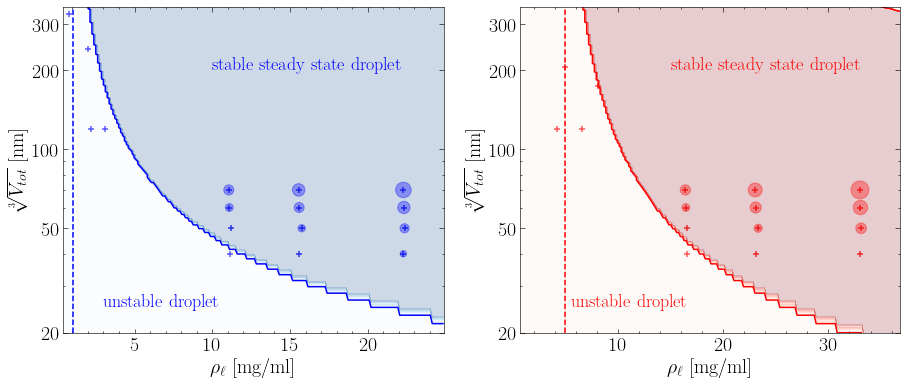

In [14]:
#Map figure
fig = plt.figure(figsize=(15,6)) 
subDDX = fig.add_subplot(1,2,2)
subFUS = fig.add_subplot(1,2,1)

#Load data for FUS and compute FUS variables 
AllSimsFUS = pd.read_excel(r'AllSimsFUS.xlsx')
VFUSAll=np.power(AllSimsFUS.L,3)
p0FUSAll=kT*(AllSimsFUS.N)/VFUSAll

#Load data for DDX4 and compute DDX4 variables 
AllSimsDDX = pd.read_excel(r'AllSimsDDX.xlsx')
VDDXAll=np.power(AllSimsDDX.L,3)
p0DDXAll=kT*(AllSimsDDX.N)/VDDXAll

#Plot Map DDX4 
subDDX.scatter(p0DDXAll*ml_nm3*weightDDX/kT,np.power(VDDXAll,1/3),color='r',marker='+',alpha=0.8)
subDDX.contourf(PP0*ml_nm3*weightDDX/kT,np.power(VVtot,1/3),CLASS_DDX,cmap='Reds',alpha=0.2)
subDDX.contour(PP0*ml_nm3*weightDDX/kT,np.power(VVtot,1/3),CLASS_DDX,[1],colors=['r'])
subDDX.plot([LD_DDX_estimate, LD_DDX_estimate],[np.min(np.power(Vtot,1/3)), np.max(np.power(Vtot,1/3))],'--',color='red',Linewidth=1.5)
subDDX.scatter(p0DDX*ml_nm3*weightDDX/kT,np.power(VDDX,1/3),color='red',s=1.5*dataDDX.Nss,alpha=0.35)
subDDX.set_xlabel('$\\rho_\ell$ [mg/ml]')
subDDX.set_ylabel('$\sqrt[3]{V_{tot}}$ [nm]')

#Plot Map FUS 
subFUS.scatter(p0FUSAll*ml_nm3*weightFUS/kT,np.power(VFUSAll,1/3),color='b',marker='+',alpha=0.8)
subFUS.contourf(PP0*ml_nm3*weightFUS/kT,np.power(VVtot,1/3),CLASS_FUS,cmap='Blues',alpha=0.2)
subFUS.contour(PP0*ml_nm3*weightFUS/kT,np.power(VVtot,1/3),CLASS_FUS,[1],colors=['b'])
subFUS.plot([LD_FUS_estimate, LD_FUS_estimate],[np.min(np.power(Vtot,1/3)), np.max(np.power(Vtot,1/3))],'--',color='blue',Linewidth=1.5)
subFUS.scatter(p0FUS*ml_nm3*weightFUS/kT,np.power(VFUS,1/3),color='blue',s=dataFUS.Nss,alpha=0.35)
subFUS.set_xlabel('$\\rho_\ell$ [mg/ml]')
subFUS.set_ylabel('$\sqrt[3]{V_{tot}}$ [nm]')

# Annotate plumed
subFUS.annotate('stable steady state droplet',xy=(10,200),color='blue',fontsize=18)
subDDX.annotate('stable steady state droplet',xy=(15,200),color='red',fontsize=18)
subFUS.annotate('unstable droplet',xy=(3,25),color='blue',fontsize=18)
subDDX.annotate('unstable droplet',xy=(5.5,25),color='red',fontsize=18)

subDDX.set_yscale('log')
subFUS.set_yscale('log')
subDDX.set_yticks([20, 50, 100, 200, 300])
subDDX.set_yticklabels([20, 50, 100, 200, 300])
subFUS.set_yticks([20, 50, 100, 200, 300])
subFUS.set_yticklabels([20, 50, 100, 200, 300])

plt.savefig('maps_FUS_DDX', dpi=600, bbox_inches='tight');


In [ ]:
fig = plt.figure(figsize=(7,7)) 
axmap = fig.add_subplot(1,1,1)


AllSimsFUS = pd.read_excel(r'AllSimsFUS.xlsx')
VFUSAll=np.power(AllSimsFUS.L,3)
p0FUSAll=kT*(AllSimsFUS.N)/VFUSAll
axmap.scatter(p0FUSAll*ml_nm3*weightFUS/kT,np.power(VFUSAll,1/3),color='b',marker='x',alpha=0.8)

AllSimsDDX = pd.read_excel(r'AllSimsDDX.xlsx')
VDDXAll=np.power(AllSimsDDX.L,3)
p0DDXAll=kT*(AllSimsDDX.N)/VDDXAll
axmap.scatter(p0DDXAll*ml_nm3*weightDDX/kT,np.power(VDDXAll,1/3),color='r',marker='x',alpha=0.8)


axmap.contour(PP0*ml_nm3*weightDDX/kT,np.power(VVtot,1/3),CLASS_DDX,[1],colors=['r'])
axmap.plot([LD_DDX_estimate, LD_DDX_estimate],[np.min(np.power(Vtot,1/3)), np.max(np.power(Vtot,1/3))],'--',color='red',Linewidth=1.5)
axmap.scatter(p0DDX*ml_nm3*weightDDX/kT,np.power(VDDX,1/3),color='red',s=dataDDX.Nss,alpha=1.0)
axmap.set_xlabel('$\\rho_\ell$ [mg/ml]')
axmap.set_ylabel('$\sqrt[3]{V_{tot}}$ [nm]')


axmap.contour(PP0*ml_nm3*weightFUS/kT,np.power(VVtot,1/3),CLASS_FUS,[1],colors=['b'])
axmap.plot([LD_FUS_estimate, LD_FUS_estimate],[np.min(np.power(Vtot,1/3)), np.max(np.power(Vtot,1/3))],'--',color='blue',Linewidth=1.5)

print(np.size(VFUS))
axmap.scatter(p0FUS*ml_nm3*weightFUS/kT,np.power(VFUS,1/3),color='blue',s=dataFUS.Nss,alpha=1.0)

axmap.set_xlabel('$\\rho_\ell$ [mg/ml]')
axmap.set_ylabel('$\sqrt[3]{V_{tot}}$ [nm]')

axmap.annotate('stable steady state droplet',xy=(17,200),color='k',fontsize=18,alpha=0.6)
axmap.annotate('unstable droplet',xy=(6,25),color='k',fontsize=18,alpha=0.6)


axmap.set_yscale('log')
axmap.set_yscale('log')
axmap.set_yticks([20, 50, 100, 200, 300])
axmap.set_yticklabels([20, 50, 100, 200, 300])
axmap.set_yticks([20, 50, 100, 200, 300])
axmap.set_yticklabels([20, 50, 100, 200, 300])

plt.savefig('maps_FUS_DDX_2', dpi=600, bbox_inches='tight');